In [93]:
import json
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# General definitions
rootdir = ".."
data_directory = os.path.join(rootdir, "hpob")
search_space_id = "4796"
part = "test"

In [3]:
# Approach definitions
num_particles = 100
num_random_trajectories = 50
horizon = 3
optimizer="sgd"
lr = 0.001
mpc_seed = 5

In [4]:
# get part files
with open(os.path.join(data_directory, "splits", f"{part}.json"), "r") as f:
    files = json.load(f)[search_space_id]

In [102]:
# initialize search space results
search_space_results = []
search_space_results_rank = []

col_names = None
# get individual task names
mdf = pd.DataFrame()
mdf_rank = pd.DataFrame()
for task in files:

    approach_results = dict()
    variant_name = "{pre_trained} {apply_lookahead}"
    for pre_trained in [True, False]:
        for apply_lookahead in [True, False]:
            approach_results_path = os.path.join(rootdir, "results", "pre-trained" if pre_trained else "random-initialization",
                                                 search_space_id, f"horizon-{horizon}",
                                                 f"trajectories-{num_random_trajectories}",
                                                 f"particles-{num_particles}",
                                                 "LookAhead" if apply_lookahead else "MPC",
                                                 optimizer, f"lr-{lr}", f"mpc-{mpc_seed}", task)
            temp_results = (100 * pd.read_csv(os.path.join(approach_results_path, "results.csv"), index_col=0)).round(4).reindex(range(96)).fillna(0)
            approach_results.update({variant_name.format(pre_trained="pre-trained" if pre_trained else "random",
                                                         apply_lookahead="LookAhead" if apply_lookahead else "MPC"):temp_results})

    for hpo_seed in range(5):
        seed_results = pd.DataFrame()
        for approach in approach_results:
            seed_results = pd.concat([seed_results, pd.DataFrame(approach_results[approach][f"seed-{hpo_seed}"]).rename(
                columns={f"seed-{hpo_seed}": approach})], axis=1)
        mdf = mdf.reset_index(drop=True)
        if col_names is None:
            col_names = seed_results.columns
        seed_results_rank = seed_results.rank(axis=1)
        seed_results = seed_results.reset_index(drop=False).rename(columns={"index": "Trial"})
        seed_results["Trial"] += 1
        rank_ = pd.melt(seed_results_rank.reset_index(drop=False), id_vars=["index"],
                value_vars=col_names).rename(columns={"variable": "Method", "value": "Rank"}).drop(columns=["index"]).reset_index(drop=True)
        regret_ = pd.melt(seed_results, id_vars=["Trial"],
                value_vars=col_names).rename(columns={"variable": "Method", "value": "Regret"}).reset_index(drop=True)

        regret_["Rank"] = rank_["Rank"]
        regret_["Task"] = task
        regret_["seed"] = hpo_seed
        mdf = pd.concat([mdf, regret_], axis=0).reset_index(drop=True)


In [106]:
mdf_slice = mdf[mdf["Trial"] == 96]
mdf_slice

,Trial,Method,Regret,Rank,Task,seed
95,96,pre-trained LookAhead,0.0000,2.5,3549,0
191,96,pre-trained MPC,0.0000,2.5,3549,0
287,96,random LookAhead,0.0000,2.5,3549,0
383,96,random MPC,0.0000,2.5,3549,0
479,96,pre-trained LookAhead,0.0000,2.5,3549,1
...,...,...,...,...,...,...
7295,96,random MPC,1.0198,2.5,23,3
7391,96,pre-trained LookAhead,0.0000,1.0,23,4
7487,96,pre-trained MPC,1.0198,3.0,23,4
7583,96,random LookAhead,1.0198,3.0,23,4


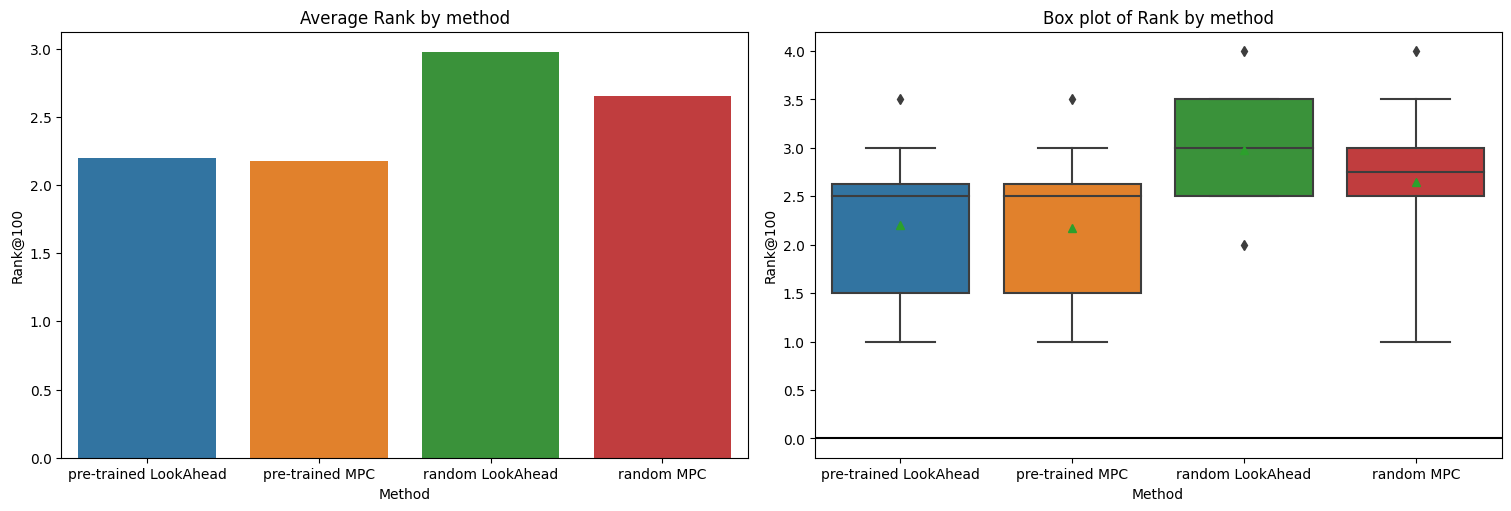

In [113]:
# BARPLOT & BOXPLOT BY METHOD
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), constrained_layout=True)
# group data for MAE barplot
mdf_grouped_temp = pd.DataFrame(mdf_slice.groupby(['Method'])['Rank'].apply(lambda x: np.mean(x))).reset_index()
mdf_grouped_temp['Method'] = pd.Categorical(mdf_grouped_temp['Method'], ordered=True)
g1=sns.barplot(data=mdf_grouped_temp, x='Method', y='Rank', ax=ax[0])
g1.set(title=f'Average Rank by method', xlabel='Method', ylabel='Rank@100')

g2=sns.boxplot(data=mdf_slice, x='Method', y='Rank', orient='v', showmeans=True, whis=[0.5, 99.5], ax=ax[1])
g2.set(title='Box plot of Rank by method', xlabel='Method', ylabel='Rank@100')
ax[1].axhline(0, color='black')

